# HW8.

by Handan Cetin | USCID: 6074572947 | github: handancetin

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

In [1]:
import os
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC
import sklearn.metrics as skM
from sklearn.cluster import KMeans, SpectralClustering

import warnings
warnings.filterwarnings('ignore') # for plots

### 1.(a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set 
from: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29. 

Download the data in https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data, which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes.

In [2]:
# read data
data = pd.read_csv('../data/wdbc.data', header = None)

# fix column names
data.rename(columns = {data.columns[0]: 'id' }, inplace = True)
data.rename(columns = {data.columns[1]: 'class' }, inplace = True)
for i in range(len(data.columns)-2):
        data.rename(columns = {data.columns[i+2]: f'att{i+1}' }, inplace = True)

# encode the class
data['class'] = data['class'].map({'M': 1, 'B': 0})

# we don't need the IDs
data = data.drop(columns = ['id'])
data

,class,att1,att2,att3,att4,att5,att6,att7,att8,att9,...,att21,att22,att23,att24,att25,att26,att27,att28,att29,att30
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### 1.(b) Monte-Carlo Simulation 
Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly selected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

#### 1.(b)i. Supervised Learning: Train an L1-penalized SVM to classify the data.
Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [3]:
# Get the scores
scores = pd.DataFrame(columns = ['accuracy', 'precision', 'recall', 'f1score', 'auc'], 
                        index = ['training', 'testing'])
# Iterate M=30 times
for i in range(0, 30): 

    # use 20% of both the positve and negative classes as the test set
    testingSet = pd.concat([data[data['class'] == 1].sample(frac = 0.2), 
                            data[data['class'] == 0].sample(frac = 0.2)], 
                            axis = 0)
    trainingSet = data.drop(testingSet.index, axis = 0).reset_index(drop = True)
    testingSet = testingSet.reset_index(drop = True)

    # seperate target and features
    trainingTarget = trainingSet['class']
    trainingFeatures = trainingSet.drop(columns = 'class')
    testingTarget = testingSet['class']
    testingFeatures = testingSet.drop(columns = 'class')

    # normalize data
    trainingFeaturesNorm = Normalizer().fit_transform(trainingFeatures)
    testingFeaturesNorm  = Normalizer().fit_transform(testingFeatures)

    # cross validation
    parameters = { 'C': [0.001, 0.01, 0.1, 10, 100, 1000, 10000] }
    gridSearch = GridSearchCV(LinearSVC(penalty = 'l1', dual = False, max_iter = 10000), 
                       parameters, cv = StratifiedKFold(n_splits = 5), scoring = 'accuracy')
    gridSearch.fit(trainingFeaturesNorm, trainingTarget)

    # model prediction (with best C)
    model = LinearSVC(penalty = 'l1', C = gridSearch.best_params_['C'], dual = False)
    model.fit(trainingFeaturesNorm, trainingTarget)
    testingPredicted  = model.predict(testingFeaturesNorm)
    trainingPredicted = model.predict(trainingFeaturesNorm)

    # calculate and save scores 
    fprTR, tprTR, thresholdsTR = skM.roc_curve(trainingTarget, model.decision_function(trainingFeaturesNorm))
    fprTE, tprTE, thresholdsTE = skM.roc_curve(testingTarget,  model.decision_function(testingFeaturesNorm) )

    scores.loc['training']['accuracy']  = np.append(scores.loc['training']['accuracy'],  model.score(trainingFeaturesNorm, trainingTarget) )
    scores.loc['training']['precision'] = np.append(scores.loc['training']['precision'], skM.precision_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['recall']    = np.append(scores.loc['training']['recall'],    skM.recall_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['f1score']   = np.append(scores.loc['training']['f1score'],   skM.f1_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['auc']       = np.append(scores.loc['training']['auc'],       skM.auc(fprTR, tprTR) )

    scores.loc['testing']['accuracy']  = np.append(scores.loc['testing']['accuracy'],  model.score(testingFeaturesNorm, testingTarget) )
    scores.loc['testing']['precision'] = np.append(scores.loc['testing']['precision'], skM.precision_score(testingTarget, testingPredicted) )
    scores.loc['testing']['recall']    = np.append(scores.loc['testing']['recall'],    skM.recall_score(testingTarget, testingPredicted) )
    scores.loc['testing']['f1score']   = np.append(scores.loc['testing']['f1score'],   skM.f1_score(testingTarget, testingPredicted) )
    scores.loc['testing']['auc']       = np.append(scores.loc['testing']['auc'],       skM.auc(fprTE, tprTE) )

# Calculate averages
avgscores = scores

avgscores.loc['training']['accuracy']  = np.round(np.nanmean(scores.loc['training']['accuracy']), 4)
avgscores.loc['training']['precision'] = np.round(np.nanmean(scores.loc['training']['precision']), 4)
avgscores.loc['training']['recall']    = np.round(np.nanmean(scores.loc['training']['recall']), 4)
avgscores.loc['training']['f1score']   = np.round(np.nanmean(scores.loc['training']['f1score']), 4)
avgscores.loc['training']['auc']       = np.round(np.nanmean(scores.loc['training']['auc']), 4)

avgscores.loc['testing']['accuracy']   = np.round(np.nanmean(scores.loc['testing']['accuracy']), 4)
avgscores.loc['testing']['precision']  = np.round(np.nanmean(scores.loc['testing']['precision']), 4)
avgscores.loc['testing']['recall']     = np.round(np.nanmean(scores.loc['testing']['recall']), 4)
avgscores.loc['testing']['f1score']    = np.round(np.nanmean(scores.loc['testing']['f1score']), 4)
avgscores.loc['testing']['auc']        = np.round(np.nanmean(scores.loc['testing']['auc']), 4)

# Print the results
print('Average scores over 30 runs are:\n')
print(avgscores)


Average scores over 30 runs are:

         accuracy precision  recall f1score     auc
training   0.9843    0.9867   0.971  0.9788  0.9986
testing    0.9664    0.9675  0.9421   0.954  0.9913


Confusion matrix for the testing set is:
 [[70  1]
 [ 2 40]]

Confusion matrix for the training set is:
 [[284   2]
 [  6 164]]

ROC curves are:


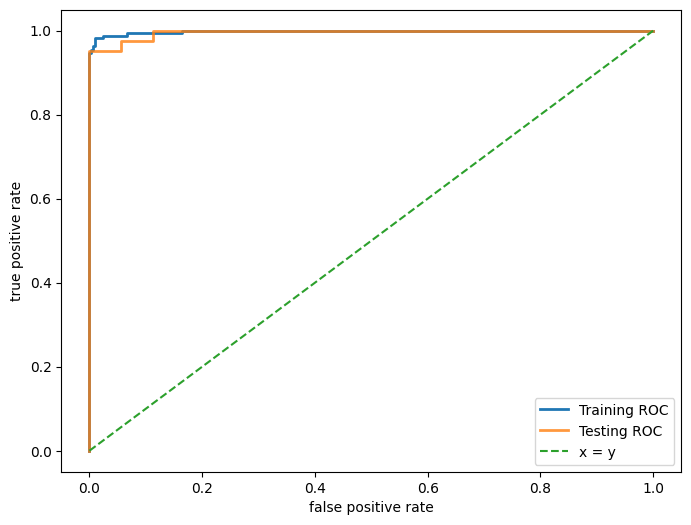

In [4]:
print('Confusion matrix for the testing set is:\n',    skM.confusion_matrix(testingTarget, testingPredicted))
print('\nConfusion matrix for the training set is:\n', skM.confusion_matrix(trainingTarget, trainingPredicted))
print('\nROC curves are:')

# ROC Curves (for training and testing sets) of the last run
plt.subplots(figsize = (8, 6))
plt.plot(fprTR, tprTR, linewidth = 2, label = 'Training ROC')
plt.plot(fprTE, tprTE, linewidth = 2, alpha = 0.8, label = 'Testing ROC')
plt.plot([0, 1], [0, 1], "--", label = 'x = y')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend()
plt.show()

##### 1.(b)ii. Semi-Supervised Learning / Self-training
select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.

##### 1.(b)ii.A&B. Train an L1-penalized SVM to classify the labeled data 
Use normalized data. Choose the penalty parameter using 5 fold cross validation.




##### 1.(b)ii.B. Find the unlabeled data point that is the farthest to the decision boundary of the SVM. 
Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the final SVM on the test data and the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [5]:
# Get the scores
scores = pd.DataFrame(columns = ['accuracy', 'precision', 'recall', 'f1score', 'auc'], 
                        index = ['training', 'testing'])

# Iterate M=30 times
for i in range(0, 30): 

    # use 20% of both the positve and negative classes as the test set
    testingSet = pd.concat([data[data['class'] == 1].sample(frac = 0.2), 
                            data[data['class'] == 0].sample(frac = 0.2)], 
                            axis = 0)
    trainingSet = data.drop(testingSet.index, axis = 0).reset_index(drop = True)
    testingSet = testingSet.reset_index(drop = True)

    # select 50% of the positive class along with 50% of the negative class in the training set as labeled data
    trainingLabeled = pd.concat([trainingSet[trainingSet['class'] == 1].sample(frac = 0.5), 
                                 trainingSet[trainingSet['class'] == 0].sample(frac = 0.5)], 
                                 axis = 0)
    
    trainingUnlabeled = trainingSet.drop(trainingLabeled.index, axis = 0).reset_index(drop = True)
    trainingLabeled = trainingLabeled.reset_index(drop = True)

    # seperate target and features
    trainingLabeledTarget = trainingLabeled['class']
    trainingLabeledFeatures = trainingLabeled.drop(columns = 'class')

    trainingUnlabeledTarget = trainingUnlabeled['class']
    trainingUnlabeledFeatures = trainingUnlabeled.drop(columns = 'class')

    trainingTarget = pd.concat([trainingLabeledTarget, trainingUnlabeledTarget])

    testingTarget = testingSet['class']
    testingFeatures = testingSet.drop(columns = 'class')

    # normalize data
    trainingLabeledFeaturesNorm   = Normalizer().fit_transform(trainingLabeledFeatures)
    trainingUnlabeledFeaturesNorm = Normalizer().fit_transform(trainingUnlabeledFeatures)
    testingFeaturesNorm  = Normalizer().fit_transform(testingFeatures)

    # cross validation
    parameters = {'C': [0.001, 0.01, 0.1, 10, 100, 1000, 10000]}
    gridSearch = GridSearchCV(LinearSVC(penalty = 'l1', dual = False, max_iter = 10000), parameters, 
                        scoring = 'accuracy', cv = StratifiedKFold(n_splits = 5))
    gridSearch.fit(trainingLabeledFeaturesNorm, trainingLabeledTarget)

    # model prediction with best c
    model = LinearSVC(penalty = 'l1', C = gridSearch.best_params_['C'], dual = False)
    model.fit(trainingLabeledFeaturesNorm, trainingLabeledTarget)

    # get decision for unlabeled data
    while len(trainingUnlabeledFeatures) > 0:

        # calculate the distances
        distancesFromBoundary = model.decision_function(trainingUnlabeledFeatures)

        # classify the farthest point
        farthestPoint = np.abs(distancesFromBoundary).argmax()
        if distancesFromBoundary[farthestPoint] < 0: 
            predictedClass = 0
        else: 
            predictedClass = 1
            
        # add this datapoint to the labeled sets with the predicted label
        trainingLabeledFeaturesNorm = np.append(trainingLabeledFeaturesNorm, [trainingUnlabeledFeatures.iloc[farthestPoint]], axis = 0)
        trainingLabeledTarget       = np.append(trainingLabeledTarget, predictedClass)
     
        # retrain the model 
        model.fit(trainingLabeledFeaturesNorm, trainingLabeledTarget)
    
        # remove the labeled datapoint from unlabeled set (for the while loop)
        trainingUnlabeledFeatures = trainingUnlabeledFeatures.drop(trainingUnlabeledFeatures.index[farthestPoint])

    # now our model has seen all the training data, predict the labels
    trainingPredicted = model.predict(trainingLabeledFeaturesNorm)
    testingPredicted  = model.predict(testingFeaturesNorm)  

    # Calculate and save scores 
    fprTR, tprTR, thresholdsTR = skM.roc_curve(trainingTarget, model.decision_function(trainingLabeledFeaturesNorm))
    fprTE, tprTE, thresholdsTE = skM.roc_curve(testingTarget,  model.decision_function(testingFeaturesNorm) )

    scores.loc['training']['accuracy']  = np.append(scores.loc['training']['accuracy'],  model.score(trainingFeaturesNorm, trainingTarget) )
    scores.loc['training']['precision'] = np.append(scores.loc['training']['precision'], skM.precision_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['recall']    = np.append(scores.loc['training']['recall'],    skM.recall_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['f1score']   = np.append(scores.loc['training']['f1score'],   skM.f1_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['auc']       = np.append(scores.loc['training']['auc'],       skM.auc(fprTR, tprTR) )

    scores.loc['testing']['accuracy']  = np.append(scores.loc['testing']['accuracy'],  model.score(testingFeaturesNorm, testingTarget) )
    scores.loc['testing']['precision'] = np.append(scores.loc['testing']['precision'], skM.precision_score(testingTarget, testingPredicted) )
    scores.loc['testing']['recall']    = np.append(scores.loc['testing']['recall'],    skM.recall_score(testingTarget, testingPredicted) )
    scores.loc['testing']['f1score']   = np.append(scores.loc['testing']['f1score'],   skM.f1_score(testingTarget, testingPredicted) )
    scores.loc['testing']['auc']       = np.append(scores.loc['testing']['auc'],       skM.auc(fprTE, tprTE) )

# Calculate averages
avgscores = scores

avgscores.loc['training']['accuracy']  = np.round(np.nanmean(scores.loc['training']['accuracy']), 4)
avgscores.loc['training']['precision'] = np.round(np.nanmean(scores.loc['training']['precision']), 4)
avgscores.loc['training']['recall']    = np.round(np.nanmean(scores.loc['training']['recall']), 4)
avgscores.loc['training']['f1score']   = np.round(np.nanmean(scores.loc['training']['f1score']), 4)
avgscores.loc['training']['auc']       = np.round(np.nanmean(scores.loc['training']['auc']), 4)

avgscores.loc['testing']['accuracy']   = np.round(np.nanmean(scores.loc['testing']['accuracy']), 4)
avgscores.loc['testing']['precision']  = np.round(np.nanmean(scores.loc['testing']['precision']), 4)
avgscores.loc['testing']['recall']     = np.round(np.nanmean(scores.loc['testing']['recall']), 4)
avgscores.loc['testing']['f1score']    = np.round(np.nanmean(scores.loc['testing']['f1score']), 4)
avgscores.loc['testing']['auc']        = np.round(np.nanmean(scores.loc['testing']['auc']), 4)

# Print the results
print('Average scores over 30 runs are:\n')
print(avgscores)

Average scores over 30 runs are:

         accuracy precision  recall f1score     auc
training   0.6247    0.4768  0.1649  0.2348  0.6449
testing    0.6381       0.1  0.0262  0.0362  0.9659


Confusion matrix for the testing set is:
 [[71  0]
 [42  0]]

Confusion matrix for the training set is:
 [[262  24]
 [156  14]]

ROC curves are:


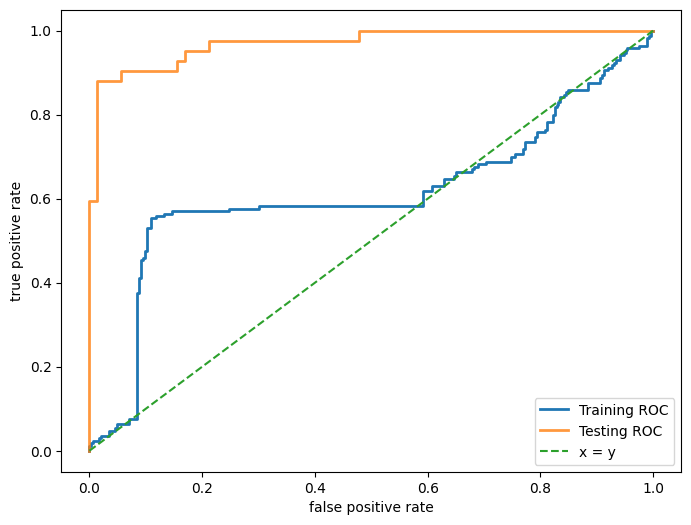

In [6]:
print('Confusion matrix for the testing set is:\n',    skM.confusion_matrix(testingTarget, testingPredicted))
print('\nConfusion matrix for the training set is:\n', skM.confusion_matrix(trainingTarget, trainingPredicted))
print('\nROC curves are:')

# ROC Curves (for training and testing sets) of the last run
plt.subplots(figsize = (8, 6))
plt.plot(fprTR, tprTR, linewidth = 2, label = 'Training ROC')
plt.plot(fprTE, tprTE, linewidth = 2, alpha = 0.8, label = 'Testing ROC')
plt.plot([0, 1], [0, 1], "--", label = 'x = y')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend()
plt.show()

The results statistics of Semi-Supervised Learning are worse than Supervised Learning.

##### 1.(b)iii. Unsupervised Learning
Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.

In [7]:
# Iterate M=30 times
k = 2
clusters = []
for i in range(0, 30): 

    # use 20% of both the positve and negative classes as the test set
    testingSet = pd.concat([data[data['class'] == 1].sample(frac = 0.2), 
                            data[data['class'] == 0].sample(frac = 0.2)], 
                            axis = 0)
    trainingSet = data.drop(testingSet.index, axis = 0).reset_index(drop = True)
    testingSet = testingSet.reset_index(drop = True)

    # seperate target and features
    trainingTarget = trainingSet['class']
    trainingFeatures = trainingSet.drop(columns = 'class')
    testingTarget = testingSet['class']
    testingFeatures = testingSet.drop(columns = 'class')

    model = KMeans(n_clusters = k, init = 'random').fit(trainingFeatures)

    # get the cluster labels
    clusters.append(model.labels_)
    

##### 1.(b)iii.A Run the k-means algorithm multiple times. 
Make sure that you initialize the algorithm randomly. How do you make sure that the algorithm was not trapped in a local minimum?

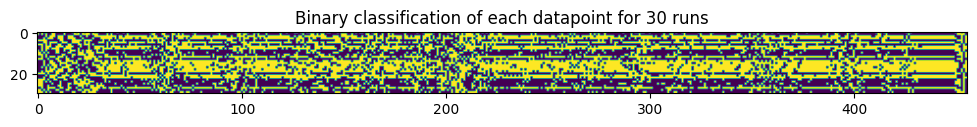

In [8]:
plt.subplots(figsize = (12, 8))
plt.imshow(clusters)
plt.title('Binary classification of each datapoint for 30 runs')
plt.show()

To make sure that the k-means algorithm is not trapped in a local minimum, we are initiating with random initial assignments. This random restart is the best way to achieve better overall solution. When we investigate the results (see the 2D heatmap above), we can see that the assignments are different in 30 iterations of the kmeans algorithm. 

##### 1.(b)iii. B & C. 

B. Compute the centers of the two clusters and find the closest 30 data points to each center. 
Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs.

C. Classify test data based on their proximity to the centers of the clusters.
Report the average accuracy, precision, recall, F1-score, and AUC over
M runs, and ROC and the confusion matrix for one of the runs for the
test data.

In [9]:
# Get the scores
scores = pd.DataFrame(columns = ['accuracy', 'precision', 'recall', 'f1score', 'auc'], 
                        index = ['training', 'testing'])

# Iterate M=30 times
k = 2
for i in range(0, 30): 

    # use 20% of both the positve and negative classes as the test set
    testingSet = pd.concat([data[data['class'] == 1].sample(frac = 0.2), 
                            data[data['class'] == 0].sample(frac = 0.2)], 
                            axis = 0)
    trainingSet = data.drop(testingSet.index, axis = 0).reset_index(drop = True)
    testingSet = testingSet.reset_index(drop = True)

    # seperate target and features
    trainingTarget = trainingSet['class']
    trainingFeatures = trainingSet.drop(columns = 'class')
    testingTarget = testingSet['class']
    testingFeatures = testingSet.drop(columns = 'class')

    model = KMeans(n_clusters = k, init = 'random').fit(trainingFeatures)

    majorityPrediction = {}
    for cl in range(0, k):
        # find the points belonging to one of the clusters
        curClusterSet = trainingFeatures[model.labels_ == cl]
        # calculate the distances from cluster center
        curDistances = ((curClusterSet - model.cluster_centers_[cl]) ** 2).sum(axis = 1)
        # read the true value and find the majority
        curMajority = trainingTarget[curDistances[0:30].index].value_counts().index[0]
        # save the majority poll as prediction
        majorityPrediction[cl] = curMajority


    # The majority poll becomes the label predicted by k-means for the members of each cluster
    trainingPredicted = [majorityPrediction[j] for j in model.labels_]

    # classify test data based on proximity
    testingPredicted = model.predict(testingFeatures)
    testingPredicted = [majorityPrediction[j] for j in testingPredicted]

    
    # Calculate and save scores 
    fprTR, tprTR, thresholdsTR = skM.roc_curve(trainingTarget, trainingPredicted)
    fprTE, tprTE, thresholdsTE = skM.roc_curve(testingTarget,  testingPredicted)

    scores.loc['training']['accuracy']  = np.append(scores.loc['training']['accuracy'],  skM.accuracy_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['precision'] = np.append(scores.loc['training']['precision'], skM.precision_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['recall']    = np.append(scores.loc['training']['recall'],    skM.recall_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['f1score']   = np.append(scores.loc['training']['f1score'],   skM.f1_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['auc']       = np.append(scores.loc['training']['auc'],       skM.auc(fprTR, tprTR) )

    scores.loc['testing']['accuracy']  = np.append(scores.loc['testing']['accuracy'],  skM.accuracy_score(testingTarget, testingPredicted) )
    scores.loc['testing']['precision'] = np.append(scores.loc['testing']['precision'], skM.precision_score(testingTarget, testingPredicted) )
    scores.loc['testing']['recall']    = np.append(scores.loc['testing']['recall'],    skM.recall_score(testingTarget, testingPredicted) )
    scores.loc['testing']['f1score']   = np.append(scores.loc['testing']['f1score'],   skM.f1_score(testingTarget, testingPredicted) )
    scores.loc['testing']['auc']       = np.append(scores.loc['testing']['auc'],       skM.auc(fprTE, tprTE) )
 

# Calculate averages
avgscores = scores

avgscores.loc['training']['accuracy']  = np.round(np.nanmean(scores.loc['training']['accuracy']), 4)
avgscores.loc['training']['precision'] = np.round(np.nanmean(scores.loc['training']['precision']), 4)
avgscores.loc['training']['recall']    = np.round(np.nanmean(scores.loc['training']['recall']), 4)
avgscores.loc['training']['f1score']   = np.round(np.nanmean(scores.loc['training']['f1score']), 4)
avgscores.loc['training']['auc']       = np.round(np.nanmean(scores.loc['training']['auc']), 4)

avgscores.loc['testing']['accuracy']   = np.round(np.nanmean(scores.loc['testing']['accuracy']), 4)
avgscores.loc['testing']['precision']  = np.round(np.nanmean(scores.loc['testing']['precision']), 4)
avgscores.loc['testing']['recall']     = np.round(np.nanmean(scores.loc['testing']['recall']), 4)
avgscores.loc['testing']['f1score']    = np.round(np.nanmean(scores.loc['testing']['f1score']), 4)
avgscores.loc['testing']['auc']        = np.round(np.nanmean(scores.loc['testing']['auc']), 4)

# Print the results
print('Average scores over 30 runs are:\n')
print(avgscores)

Average scores over 30 runs are:

         accuracy precision recall f1score  auc
training   0.3728    0.3728    1.0  0.5431  0.5
testing    0.3717    0.3717    1.0  0.5419  0.5


Confusion matrix for the testing set is:
 [[ 0 71]
 [ 0 42]]

Confusion matrix for the training set is:
 [[  0 286]
 [  0 170]]

ROC curves are:


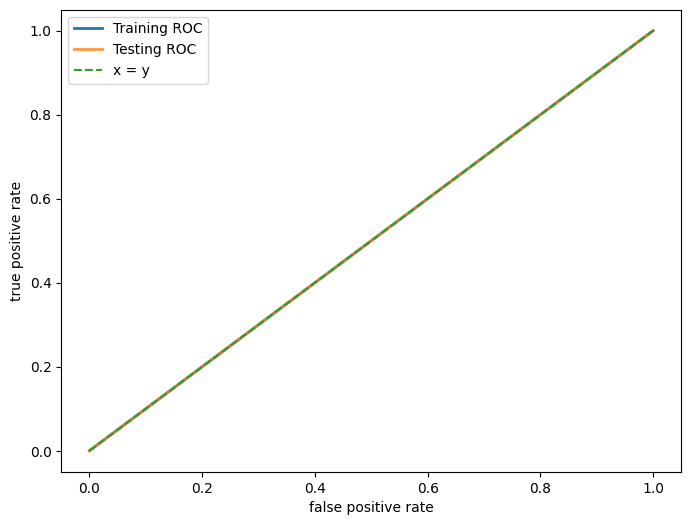

In [10]:
print('Confusion matrix for the testing set is:\n',    skM.confusion_matrix(testingTarget, testingPredicted))
print('\nConfusion matrix for the training set is:\n', skM.confusion_matrix(trainingTarget, trainingPredicted))
print('\nROC curves are:')

# ROC Curves (for training and testing sets) of the last run
plt.subplots(figsize = (8, 6))
plt.plot(fprTR, tprTR, linewidth = 2, label = 'Training ROC')
plt.plot(fprTE, tprTE, linewidth = 2, alpha = 0.8, label = 'Testing ROC')
plt.plot([0, 1], [0, 1], "--", label = 'x = y')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend()
plt.show()

The resulting statistics of Unsupervised Learning is way worse than Semi-Supervised Learning which was worse than Supervised Learning. This was expected and the observations are common. This assignment shows that labeled data is very important in the machine learning practices.

#### 1.(b)iv. Spectral Clustering
Repeat 1(b)iii using spectral clustering, which is clustering based on kernels.3 Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit−predict method.

Spectral clustering, an unsupervised machine learning method, identifies clusters by using the spectral properties of a similarity graph. These spectral properties can be similarity matrices or laplacian matrices (calculated from eigenvalues and eigenvectors). The data is first converted into a graph representation, then each datapoint put into distinct clusters according to calculation made on this graph.

In [11]:
# Get the scores
scores = pd.DataFrame(columns = ['accuracy', 'precision', 'recall', 'f1score', 'auc'], 
                        index = ['training', 'testing'])

# Iterate M=30 times
k = 2 
for i in range(0, 30):
    # use 20% of both the positve and negative classes as the test set
    testingSet = pd.concat([data[data['class'] == 1].sample(frac = 0.2), 
                            data[data['class'] == 0].sample(frac = 0.2)], 
                            axis = 0)
    trainingSet = data.drop(testingSet.index, axis = 0).reset_index(drop = True)
    testingSet = testingSet.reset_index(drop = True)

    # seperate target and features
    trainingTarget = trainingSet['class']
    trainingFeatures = trainingSet.drop(columns = 'class')
    testingTarget = testingSet['class']
    testingFeatures = testingSet.drop(columns = 'class')

    # normalize data
    trainingFeaturesNorm = Normalizer().fit_transform(trainingFeatures)
    testingFeaturesNorm  = Normalizer().fit_transform(testingFeatures)
    
    # prediction (gamma is set to 1)
    trainingPredicted = SpectralClustering(n_clusters = k, gamma = 1, affinity = 'rbf').fit_predict(trainingFeaturesNorm)
    testingPredicted  = SpectralClustering(n_clusters = k, gamma = 1, affinity = 'rbf').fit_predict(testingFeaturesNorm)
    
    # Calculate and save scores 
    fprTR, tprTR, thresholdsTR = skM.roc_curve(trainingTarget, trainingPredicted)
    fprTE, tprTE, thresholdsTE = skM.roc_curve(testingTarget,  testingPredicted)

    scores.loc['training']['accuracy']  = np.append(scores.loc['training']['accuracy'],  skM.accuracy_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['precision'] = np.append(scores.loc['training']['precision'], skM.precision_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['recall']    = np.append(scores.loc['training']['recall'],    skM.recall_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['f1score']   = np.append(scores.loc['training']['f1score'],   skM.f1_score(trainingTarget, trainingPredicted) )
    scores.loc['training']['auc']       = np.append(scores.loc['training']['auc'],       skM.auc(fprTR, tprTR) )

    scores.loc['testing']['accuracy']  = np.append(scores.loc['testing']['accuracy'],  skM.accuracy_score(testingTarget, testingPredicted) )
    scores.loc['testing']['precision'] = np.append(scores.loc['testing']['precision'], skM.precision_score(testingTarget, testingPredicted) )
    scores.loc['testing']['recall']    = np.append(scores.loc['testing']['recall'],    skM.recall_score(testingTarget, testingPredicted) )
    scores.loc['testing']['f1score']   = np.append(scores.loc['testing']['f1score'],   skM.f1_score(testingTarget, testingPredicted) )
    scores.loc['testing']['auc']       = np.append(scores.loc['testing']['auc'],       skM.auc(fprTE, tprTE) )
 

# Calculate averages
avgscores = scores

avgscores.loc['training']['accuracy']  = np.round(np.nanmean(scores.loc['training']['accuracy']), 4)
avgscores.loc['training']['precision'] = np.round(np.nanmean(scores.loc['training']['precision']), 4)
avgscores.loc['training']['recall']    = np.round(np.nanmean(scores.loc['training']['recall']), 4)
avgscores.loc['training']['f1score']   = np.round(np.nanmean(scores.loc['training']['f1score']), 4)
avgscores.loc['training']['auc']       = np.round(np.nanmean(scores.loc['training']['auc']), 4)

avgscores.loc['testing']['accuracy']   = np.round(np.nanmean(scores.loc['testing']['accuracy']), 4)
avgscores.loc['testing']['precision']  = np.round(np.nanmean(scores.loc['testing']['precision']), 4)
avgscores.loc['testing']['recall']     = np.round(np.nanmean(scores.loc['testing']['recall']), 4)
avgscores.loc['testing']['f1score']    = np.round(np.nanmean(scores.loc['testing']['f1score']), 4)
avgscores.loc['testing']['auc']        = np.round(np.nanmean(scores.loc['testing']['auc']), 4)

# Print the results
print('Average scores over 30 runs are:\n')
print(avgscores)

Average scores over 30 runs are:

         accuracy precision  recall f1score     auc
training    0.601    0.6632  0.5541  0.5881  0.5915
testing    0.7086    0.7618  0.6325  0.6781   0.693


Confusion matrix for the testing set is:
 [[71  0]
 [13 29]]

Confusion matrix for the training set is:
 [[  6 280]
 [122  48]]

ROC curves are:


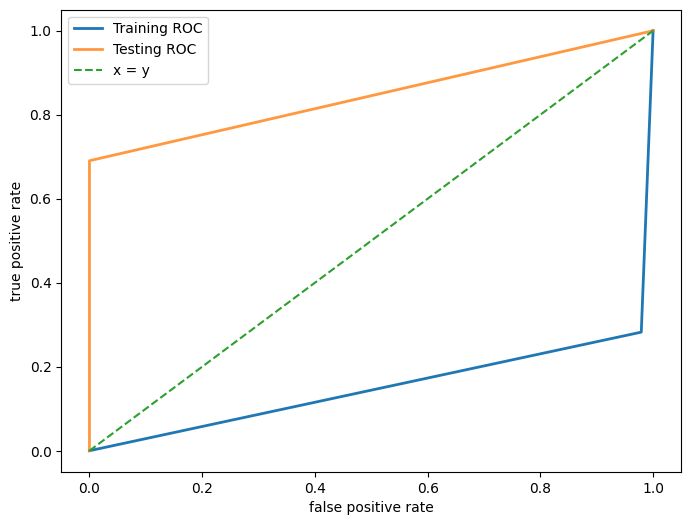

In [12]:
print('Confusion matrix for the testing set is:\n',    skM.confusion_matrix(testingTarget, testingPredicted))
print('\nConfusion matrix for the training set is:\n', skM.confusion_matrix(trainingTarget, trainingPredicted))
print('\nROC curves are:')

# ROC Curves (for training and testing sets) of the last run
plt.subplots(figsize = (8, 6))
plt.plot(fprTR, tprTR, linewidth = 2, label = 'Training ROC')
plt.plot(fprTE, tprTE, linewidth = 2, alpha = 0.8, label = 'Testing ROC')
plt.plot([0, 1], [0, 1], "--", label = 'x = y')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend()
plt.show()

#### 1.(b)v. Compare the results you obtained by those methods
One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled. One can expect that unsupervised learning underperforms in such situations. 

My results are in agreement with this statement. Unsupervised method underperformed compared to semi-supervised method. Supervised method (with all the labels) was the best model for prediction, performed really well. 

## 2. Active Learning Using Support Vector Machines

### 2.(a) Download the banknote authentication Data Set 
from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. 

Choose 472 data points randomly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.

In [13]:
data = pd.read_csv('../data/data_banknote_authentication.txt', header = None)
data.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
data

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [14]:
testingSet = data.sample(frac = 472/len(data))
trainingSet = data.drop(testingSet.index, axis = 0).reset_index(drop = True)
testingSet = testingSet.reset_index(drop = True)
print('Data has splitted into training (n = ' + str(len(trainingSet)) + ') and testing (n = ' + str(len(testingSet)) +') sets.')

Data has splitted into training (n = 900) and testing (n = 472) sets.


In [15]:
testingSet

,variance,skewness,curtosis,entropy,class
0,-3.38840,-8.21500,10.331500,0.981870,1
1,-5.03010,7.50320,-0.133960,-7.503400,1
2,3.93100,1.85410,-0.023425,1.231400,0
3,-0.28015,3.07290,-3.385700,-2.915500,1
4,5.78230,5.57880,-2.408900,-0.056479,0
...,...,...,...,...,...
467,2.01650,-0.25246,5.170700,1.076300,0
468,2.10800,6.79550,-0.170800,0.490500,0
469,3.51890,6.33200,-1.779100,-0.020273,0
470,-1.80760,-8.81310,8.708600,-0.216820,1


In [16]:
# seperate target and features
trainingTarget   = trainingSet['class'] 
trainingFeatures = trainingSet.drop(columns = 'class')

testingTarget   = testingSet['class'] 
testingFeatures = testingSet.drop(columns = 'class')

### 2.(b) Repeat each of the following two procedures 50 times. 
You will have 50 errors for 90 SVMs per each procedure.

#### 2.(b)i. Train a SVM with a pool of 10 randomly selected data points 
from the training set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation. Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning.

In [25]:
# Iterate 50 times
passiveErrors = pd.DataFrame()
for i in range(0, 50):

    rowNumbers = np.arange(trainingFeatures.shape[0])
    errors = []
    pool = []
    
    while len(rowNumbers) > 0:
        # randomize the datapoints
        np.random.shuffle(rowNumbers)

        # select 10 of them and add selected to the pool
        curSelectedTen = rowNumbers[:10]
        pool.extend(curSelectedTen)
        
        # remove the selecteds for the while loop
        rowNumbers = rowNumbers[10:]

        # cross validation
        parameters = { 'C': [ 0.01, 0.1, 10, 100, 1000] }
        gridSearch = GridSearchCV(LinearSVC(penalty = 'l1', dual = False, max_iter = 10000), 
                        parameters, cv = StratifiedKFold(n_splits = 5), scoring = 'accuracy')
        gridSearch.fit(trainingFeatures.iloc[pool], trainingTarget.iloc[pool])
    
        # model prediction (with best C)
        model = LinearSVC(penalty = 'l1', C = gridSearch.best_params_['C'], dual = False)
        model.fit(trainingFeatures.iloc[pool], trainingTarget.iloc[pool])
        testingPredicted  = model.predict(testingFeatures)

        # calculate the error
        errors.append(1 - skM.accuracy_score(testingTarget, testingPredicted))

    # Save the errors before next MC
    passiveErrors.loc[:, ['err' + str(i+1)]] = errors

In [35]:
passiveErrors

,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,...,err41,err42,err43,err44,err45,err46,err47,err48,err49,err50
0,0.063559,0.158898,0.444915,0.122881,0.110169,0.351695,0.076271,0.444915,0.036017,0.105932,...,0.108051,0.033898,0.029661,0.050847,0.116525,0.101695,0.038136,0.088983,0.305085,0.222458
1,0.069915,0.150424,0.082627,0.103814,0.033898,0.091102,0.063559,0.055085,0.025424,0.131356,...,0.027542,0.023305,0.052966,0.052966,0.065678,0.012712,0.031780,0.031780,0.059322,0.044492
2,0.038136,0.086864,0.074153,0.029661,0.023305,0.025424,0.016949,0.046610,0.040254,0.116525,...,0.027542,0.061441,0.048729,0.059322,0.093220,0.014831,0.033898,0.027542,0.059322,0.021186
3,0.012712,0.052966,0.069915,0.014831,0.067797,0.067797,0.012712,0.027542,0.044492,0.010593,...,0.023305,0.025424,0.010593,0.036017,0.144068,0.014831,0.025424,0.031780,0.046610,0.012712
4,0.050847,0.019068,0.065678,0.025424,0.057203,0.019068,0.014831,0.021186,0.040254,0.029661,...,0.021186,0.036017,0.023305,0.067797,0.019068,0.019068,0.016949,0.029661,0.010593,0.019068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.006356,...,0.006356,0.008475,0.008475,0.008475,0.008475,0.008475,0.006356,0.008475,0.008475,0.008475
86,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,...,0.006356,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475
87,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475
88,0.008475,0.006356,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.006356,...,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475


#### 2.(b)ii. Train a SVM with a pool of 10 randomly selected data points 
from the training set5 using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM6 and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning

In [107]:
# Iterate 50 times
activeErrors = pd.DataFrame()
for i in range(0, 50):
    errors = []
    pool = []
    rowNumbers = np.arange(trainingFeatures.shape[0])

    # initialize: select random 10 and add to the pool 
    randomTen = np.random.randint(low = 0, high = len(rowNumbers)-1, size = 10)
    pool.extend(randomTen)
    rowNumbers = np.delete(rowNumbers, randomTen)
  
    # continue adding and fitting
    while len(rowNumbers) > 0:
        
        # cross validation
        parameters = { 'C': [0.01, 0.01, 0.1, 10, 100, 1000] }
        gridSearch = GridSearchCV(LinearSVC(penalty = 'l1', dual = False, max_iter = 10000), 
                        parameters, cv = StratifiedKFold(n_splits = 5), scoring = 'accuracy')
        gridSearch.fit(trainingFeatures.iloc[pool], trainingTarget.iloc[pool])

        # model prediction (with best C)
        model = LinearSVC(penalty = 'l1', C = gridSearch.best_params_['C'], dual = False)
        model.fit(trainingFeatures.iloc[pool], trainingTarget.iloc[pool])
        testingPredicted  = model.predict(testingFeatures)

        # calculate the error
        errors.append(1 - skM.accuracy_score(testingTarget, testingPredicted))

        # select next 10 by the distance and add to the pool
        distances = model.decision_function(trainingFeatures.iloc[rowNumbers])
        curSelectedTen = distances.argsort()[:10] 
        pool.extend(curSelectedTen)

        # remove the selecteds for the while loop
        rowNumbers = np.delete(rowNumbers, curSelectedTen)

    if len(rowNumbers) == 0:
        # full pool: model prediction
        model = LinearSVC(penalty = 'l1', C = gridSearch.best_params_['C'], dual = False)
        model.fit(trainingFeatures.iloc[pool], trainingTarget.iloc[pool])
        testingPredicted  = model.predict(testingFeatures)

        # calculate the error
        errors.append(1 - skM.accuracy_score(testingTarget, testingPredicted))
        
    # Save the errors before the next MC
    activeErrors['err' + str(i+1)] = errors

In [108]:
activeErrors

,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,...,err41,err42,err43,err44,err45,err46,err47,err48,err49,err50
0,0.167373,0.086864,0.046610,0.031780,0.250000,0.144068,0.108051,0.194915,0.091102,0.025424,...,0.154661,0.362288,0.088983,0.116525,0.052966,0.127119,0.252119,0.101695,0.125000,0.110169
1,0.112288,0.154661,0.048729,0.012712,0.224576,0.082627,0.105932,0.177966,0.207627,0.027542,...,0.108051,0.158898,0.084746,0.072034,0.055085,0.091102,0.046610,0.057203,0.108051,0.061441
2,0.074153,0.080508,0.059322,0.057203,0.080508,0.059322,0.099576,0.171610,0.154661,0.065678,...,0.108051,0.141949,0.082627,0.055085,0.055085,0.074153,0.046610,0.014831,0.072034,0.105932
3,0.065678,0.197034,0.048729,0.012712,0.061441,0.059322,0.099576,0.171610,0.161017,0.065678,...,0.108051,0.103814,0.063559,0.067797,0.059322,0.069915,0.046610,0.021186,0.097458,0.097458
4,0.059322,0.067797,0.091102,0.059322,0.061441,0.059322,0.099576,0.163136,0.163136,0.080508,...,0.108051,0.116525,0.069915,0.067797,0.059322,0.063559,0.110169,0.048729,0.069915,0.055085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.141949,0.171610,0.044492,0.063559,0.108051,0.139831,0.146186,0.156780,0.171610,0.122881,...,0.105932,0.127119,0.154661,0.086864,0.116525,0.108051,0.161017,0.131356,0.101695,0.114407
86,0.141949,0.171610,0.044492,0.063559,0.114407,0.095339,0.146186,0.152542,0.171610,0.118644,...,0.091102,0.135593,0.154661,0.086864,0.116525,0.108051,0.161017,0.139831,0.101695,0.116525
87,0.141949,0.171610,0.044492,0.063559,0.118644,0.095339,0.148305,0.158898,0.173729,0.120763,...,0.091102,0.133475,0.158898,0.086864,0.116525,0.110169,0.161017,0.137712,0.101695,0.114407
88,0.144068,0.171610,0.044492,0.063559,0.118644,0.097458,0.148305,0.161017,0.175847,0.133475,...,0.091102,0.135593,0.158898,0.086864,0.120763,0.112288,0.161017,0.144068,0.101695,0.116525


### 2.(c) Average the 50 test errors for each of the incrementally trained 90 SVMs 
in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation

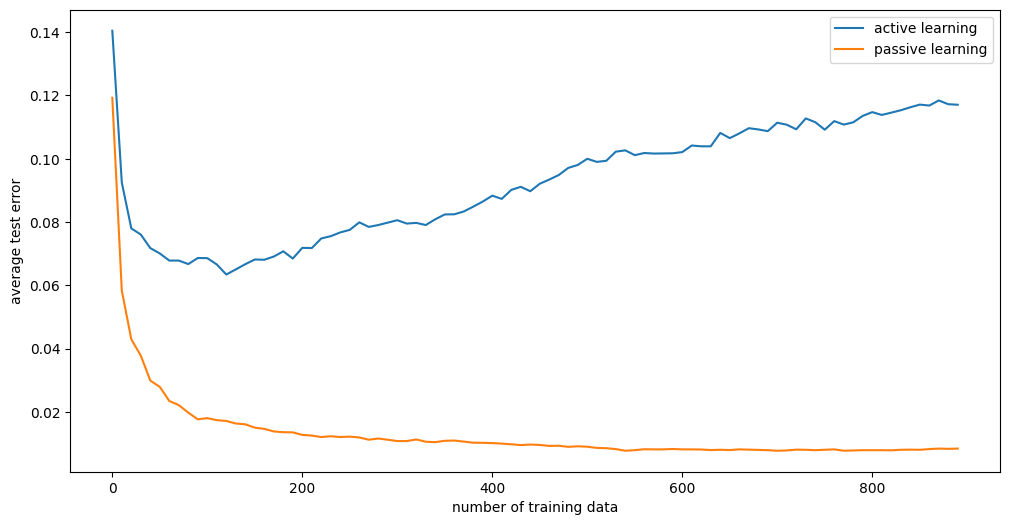

In [152]:
# calculate the averages
avgActiveErrors = activeErrors.mean(axis = 1)
avgPassiveErrors = passiveErrors.mean(axis = 1)

# plot the monte carlo learning curve
plt.figure(figsize = (12, 6))
plt.plot(range(0, len(avgActiveErrors)*10, 10), avgActiveErrors.values,  label = 'active learning')
plt.plot(range(0, len(avgPassiveErrors)*10, 10), avgPassiveErrors.values, label = 'passive learning')
plt.xlabel('number of training data')
plt.ylabel('average test error')
plt.legend()
plt.show()

We can see that the error for passive learning is always decreasing, while the active learning curve decreases until some point, then starts increasing. This makes sense since, for the passive learning, we are always introducing a random datapoints to improve the model, thus always new information is gained/learnt. On the other hand, we are providing the best datapoints to train on active learning model from the start, thus, after sometime, the model does not improve anymore since the datapoints are further away.